# IMPORT ESSENTIAL PYTHON LIBRARIES

In [23]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [24]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier model from Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # to plot the two-way Confusion Matrix
from sklearn.tree import plot_tree # to plot the trained Decision Tree

In [25]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# IMPORT THE DATASET

We will use the data stored in `cleaned-alzheimers-dataset.csv` created at the end of `Data Extraction and Cleaning`

In [26]:
alzheimersData = pd.read_csv('cleaned-alzheimers-dataset.csv',index_col= 0)
alzheimersData

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...
368,M,82,16.0,1.0,28.0,0.5,1693,0.694,1.037
369,M,86,16.0,1.0,26.0,0.5,1688,0.675,1.040
370,F,61,13.0,2.0,30.0,0.0,1319,0.801,1.331
371,F,63,13.0,2.0,30.0,0.0,1327,0.796,1.323


# CREATING A MODEL FOR `CDR`: Attempt 1

## Encode Categorical Variables

`DecisionTreeClassifier` in `sklearn` does not handle categorical variables directly as a part of the current implementation. Thus, there is a need to encode the levels of a categorical variable as integers. For categorical variables which may not be *ordinal*, `OneHotEncoding` from `sklearn` preprocessing module will be used.

TO CHECK: `Educ`and `SES`are already encoded as integers in the cleaned dataset. `M/F` - Gender is not ordinal. Hence, it should be encoded by `OneHotEncoding` 

In [27]:
# OneHotEncoding of categorical predictors (not the response)
alzheimersData_gender = alzheimersData[['M/F']]
ohe.fit(alzheimersData_gender)
alzheimersData_gender_ohe = pd.DataFrame(ohe.transform(alzheimersData_gender).toarray(), 
                                  columns=ohe.get_feature_names_out(alzheimersData_gender.columns))

# Check the encoded variables
alzheimersData_gender.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 0 to 372
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   M/F     608 non-null    object
dtypes: object(1)
memory usage: 9.5+ KB


In [28]:
# Assuming alzheimersData_gender_ohe is one-hot encoded gender features
alzheimersData_num = alzheimersData[['Age', 'MMSE']]
alzheimersData_cat = alzheimersData[['Educ', 'SES']]
alzheimersData_response = alzheimersData['CDR']

# Perform One-Hot Encoding on categorical features
alzheimersData_cat_ohe = pd.get_dummies(alzheimersData_cat)

# Concatenate numeric features, one-hot encoded categorical features, and response variable
alzheimersData_ohe = pd.concat([alzheimersData_num, alzheimersData_cat_ohe, alzheimersData_response], axis=1)

# Check the final dataframe
alzheimersData_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 0 to 372
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     608 non-null    int64  
 1   MMSE    606 non-null    float64
 2   Educ    608 non-null    float64
 3   SES     570 non-null    float64
 4   CDR     608 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 28.5 KB


## Create and Fit the Model

To ensure that 'CDR' is treated as a categorical variable representing the different classes ('Normal', 'Very Mild', 'Mild', 'Moderate'), explicitly convert it to the categorical data type using pd.Categorical().

In [38]:
alzheimersData_ohe['CDR'] = pd.Categorical(alzheimersData_ohe['CDR'], categories=[0, 0.5, 1, 2, 3], ordered=True).codes.astype(int)
print(alzheimersData_ohe['CDR'].unique())

[0 1 2 3]


Finally, after the encoding is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

In [39]:
# Extract Response and Predictors
y = pd.DataFrame(alzheimersData_ohe['CDR']) #Response
x = pd.DataFrame(alzheimersData_ohe.drop('CDR', axis = 1)) #Predictors

A simple Python function can be written and called

In [44]:
def ClassificationTree(predictor, response, depth):
    
    # Split the Legendary-Total Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(predictor, response, test_size=0.25, random_state=25)
    
    # Decision Tree using Train Data
    dectree = DecisionTreeClassifier(max_depth = depth)
    dectree.fit(X_train, y_train)
    
    # Predict Response values corresponding to Predictor
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)
    
    
    # Plot the trained Decision Tree
    f = plt.figure(figsize=(12,12))
    plot_tree(dectree, filled=True, rounded=True, 
          feature_names= X_train.columns.tolist(), # Convert Index object to list
          class_names=['Normal','Very Mild','Mild', 'Moderate', 'Severe']) 
    
    return X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, dectree

### Classification Tree Model of Max Depth 3

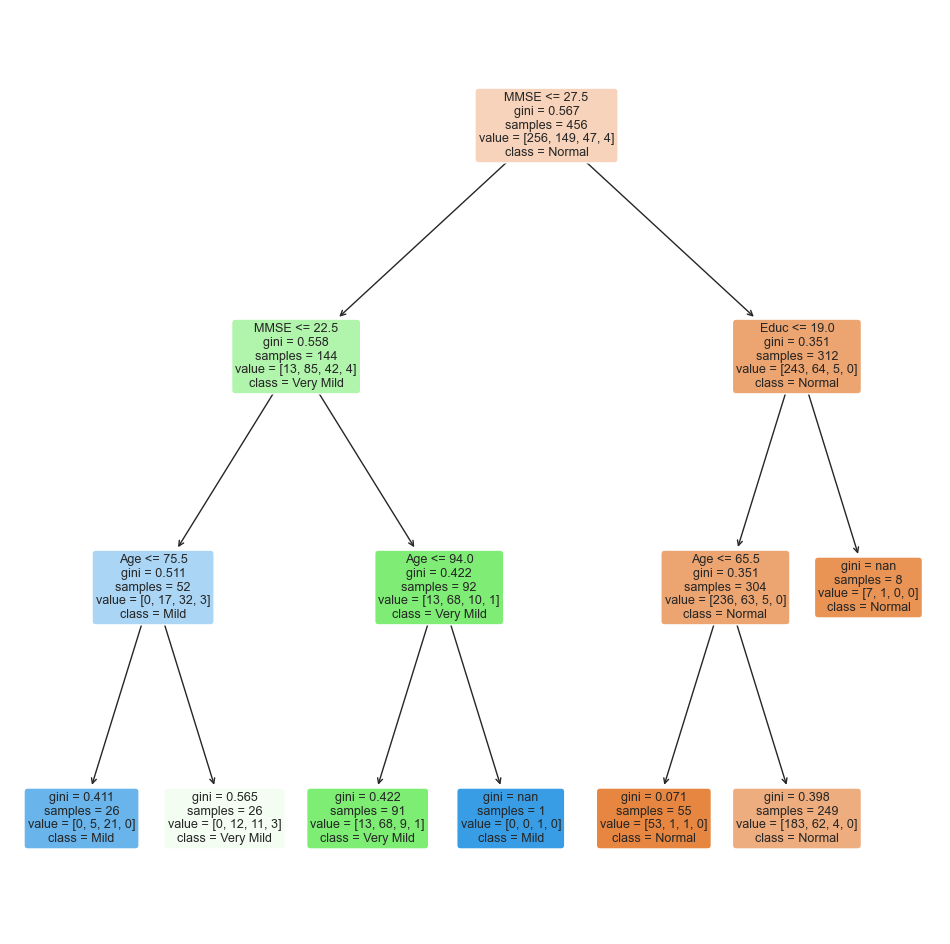

In [45]:
X_train3, X_test3, y_train3, y_test3, y_train_pred3, y_test_pred3, dectree3 = ClassificationTree(x, y, 3)

### Classification Tree Model of Max Depth 4

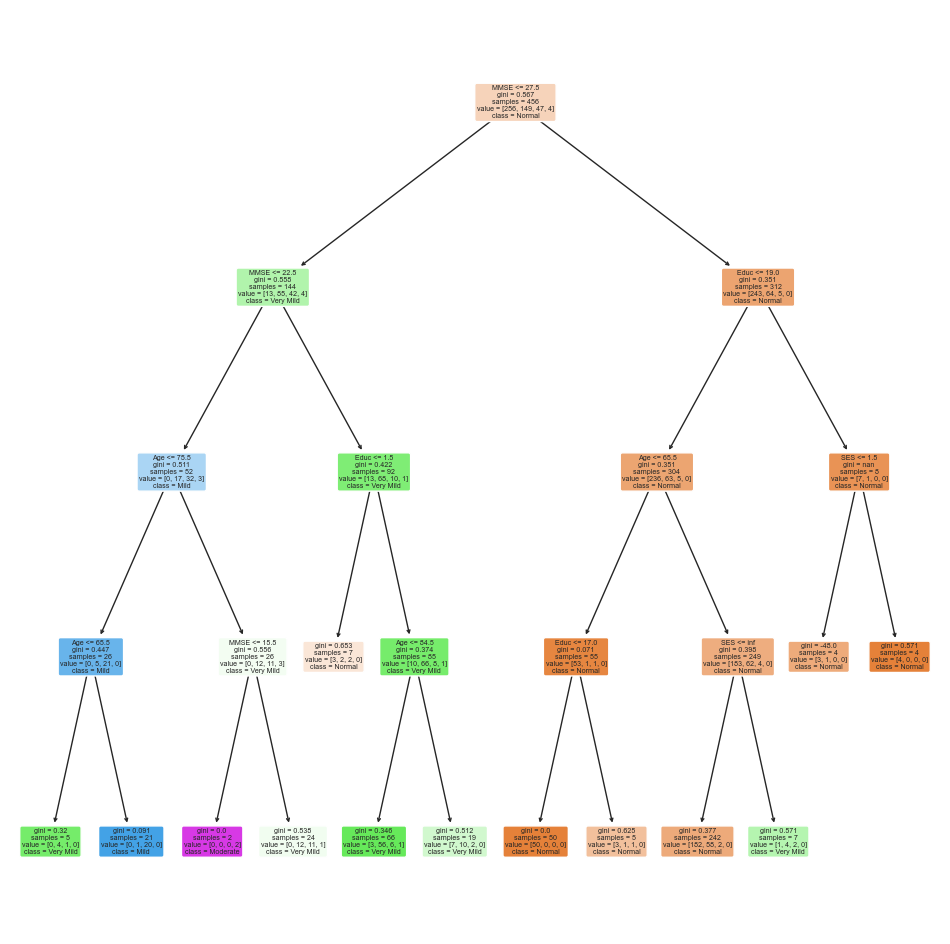

In [46]:
X_train4, X_test4, y_train4, y_test4, y_train_pred4, y_test_pred4, dectree4 = ClassificationTree (x, y, 4)

## Check the Accuracy of the Model

Again, a simple Python function can be written and called

In [48]:
def confusionmatrixValues(confusionmatrix):
    tn = confusionmatrix[0][0]
    fp = confusionmatrix[0][1]
    fn = confusionmatrix[1][0]
    tp = confusionmatrix[1][1]

    return tn, fp, fn, tp

def printConfusionMatrix(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred , dectree):
    
    confusionmatrix_train = confusion_matrix(y_train, y_train_pred)
    confusionmatrix_test = confusion_matrix(y_test, y_test_pred)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusionmatrix_train,
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusionmatrix_test, 
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


    tn_train, fp_train, fn_train, tp_train = confusionmatrixValues(confusionmatrix_train)
    tn_test, fp_test, fn_test, tp_test = confusionmatrixValues(confusionmatrix_test)
    

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", dectree.score(X_train, y_train))
    print("True Positive Rate (TPR) \t:", tp_train / (tp_train + fn_train))
    print("False Positive Rate (FPR) \t:", fp_train / (fp_train + tn_train))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", dectree.score(X_test, y_test))
    print("True Positive Rate (TPR) \t:", tp_test / (tp_test + fn_test))
    print("False Positive Rate (FPR) \t:", fp_test / (fp_test + tn_test))
    print()

    return

### Confusion Matrix for Classification Tree Model of Max Depth 3

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.756578947368421
True Positive Rate (TPR) 	: 0.5555555555555556
False Positive Rate (FPR) 	: 0.05078125

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7171052631578947
True Positive Rate (TPR) 	: 0.6578947368421053
False Positive Rate (FPR) 	: 0.11764705882352941



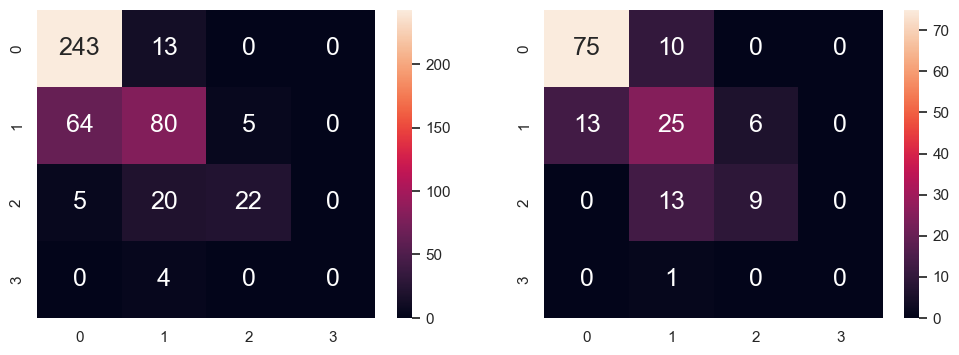

In [49]:
printConfusionMatrix(X_train3, X_test3, y_train3, y_test3, y_train_pred3, y_test_pred3, dectree3)

### Confusion Matrix for Classification Tree Model of Max Depth 4

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7741228070175439
True Positive Rate (TPR) 	: 0.581081081081081
False Positive Rate (FPR) 	: 0.04296875

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7368421052631579
True Positive Rate (TPR) 	: 0.7
False Positive Rate (FPR) 	: 0.11764705882352941



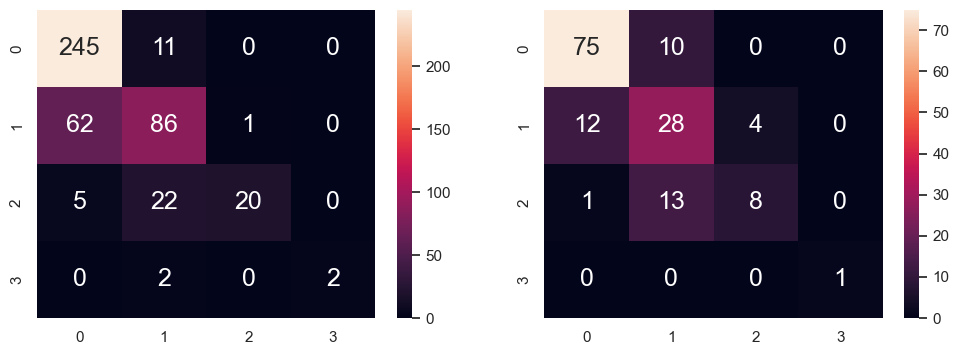

In [50]:
printConfusionMatrix(X_train4, X_test4, y_train4, y_test4, y_train_pred4, y_test_pred4, dectree4)